In [ ]:
!pip install networkx

ERROR: Operation cancelled by user


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/prescription_2017_atc.csv", index_col=0)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
df

In [ ]:
missing_counts = df.isnull().sum()
missing_counts

Unnamed: 0    0
IDV_ID        0
KEY_SEQ       0
SEQ_NO        0
AGE_GROUP     0
SIDO          0
GNL_NM_CD     0
5_GNL         0
mfds_no       0
ATC           0
dtype: int64

# RF Data making

In [ ]:
regression = pd.read_csv('/content/drive/MyDrive/데마 팀플/기말 Project/DATA/regression.csv', index_col=0)

In [ ]:
regression

,CF0.01,CV,COUNT,Rebate
1001A,32.000000,16.274335,30.0,0
1003A,614.000000,659.948818,7158.0,0
1005A,210.000000,302.638789,796.0,0
1006A,437.000000,544.245475,2324.0,0
1007A,840.000000,1002.037426,82314.0,0
...,...,...,...,...
6396A,530.088462,431.000000,2900.0,1
6453A,533.180055,397.000000,2764.0,1
6484A,343.549035,291.000000,1276.0,1
6485A,433.427353,370.000000,2092.0,1


In [ ]:
# '5_GNL'을 기준으로 그룹화하고 평균 계산
grouped = df.groupby('5_GNL')[['DD_MQTY_FREQ', 'DD_EXEC_FREQ', 'MDCN_EXEC_FREQ', 'UN_COST']].mean().reset_index()

# '5_GNL'을 기준으로 'regression' 데이터프레임과 병합
regression.index.name = '5_GNL'
regression.reset_index(inplace=True)
regression = regression.merge(grouped, on='5_GNL', suffixes=('', '_mean'))
regression.set_index('5_GNL', inplace=True)


# 열 이름 변경 (선택 사항)
regression.rename(columns={
    'DD_MQTY_FREQ_mean': 'DD_MQTY_FREQ',
    'DD_EXEC_FREQ_mean': 'DD_EXEC_FREQ',
    'MDCN_EXEC_FREQ_mean': 'MDCN_EXEC_FREQ',
    'un_cost_mean': 'UN_COST'
}, inplace=True)

regression

,CF0.01,CV,COUNT,Rebate,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST
5_GNL,,,,,,,,
1001A,32.0,16.274335,30.0,0,1.600000,2.866667,49.666667,771.400000
1003A,614.0,659.948818,7158.0,0,1.013426,2.019639,33.128846,289.000000
1005A,210.0,302.638789,796.0,0,1.559976,2.029691,24.630641,173.529691
1006A,437.0,544.245475,2324.0,0,1.011936,2.128647,49.549072,117.542440
1007A,840.0,1002.037426,82314.0,0,0.965439,2.043800,13.796936,211.293464
...,...,...,...,...,...,...,...,...
8002C,53.0,55.296718,289.0,0,53.093003,1.069966,4.035836,756.000000
8005C,81.0,71.190381,163.0,0,1.119512,1.024390,1.252033,26300.000000
8009C,71.0,73.080702,961.0,0,1.985252,1.085294,1.466912,16075.000000


In [ ]:
regression.to_csv('/content/drive/MyDrive/regression_2.csv')

In [ ]:
print((regression['Rebate']==1).sum())

33


# 식약분류

In [ ]:
df_tmp = df.groupby('KEY_SEQ')['mfds_no'].apply(set).apply(list).to_list()
print(df_tmp[:10])

[[232, 114, 222], [618, 395, 222, 114], [114, 245, 239], [396, 214], [232, 141, 222], [322, 239, 114, 117, 119], [232, 123, 124, 239], [218, 211, 213, 214], [232, 264, 141], [339, 117, 119, 313, 218]]


In [ ]:
import itertools
all_combinations = []

for i in range(len(df_tmp)):
  codes = df_tmp[i]

# 2개씩 뽑는 조합 생성
  combinations = list(itertools.combinations(codes, 2))
  all_combinations.extend(combinations)

df_sna = pd.DataFrame(all_combinations, columns=['source', 'target'])

df_sna.head()

,source,target
0,232,114
1,232,222
2,114,222
3,618,395
4,618,222


In [ ]:
df_grouped = df_sna

df_grouped['source_target'] = df_grouped.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)

df_grouped = df_sna.groupby('source_target').size().reset_index(name='weight')

df_grouped[['source', 'target']] = pd.DataFrame(df_grouped['source_target'].tolist(), index=df_grouped.index)

df_grouped.drop(columns=['source_target'], inplace=True)

df_grouped

,weight,source,target
0,19,111,112
1,2,111,113
2,8,111,114
3,13,111,117
4,2,111,119
...,...,...,...
3260,257,629,821
3261,2,641,721
3262,229,641,811
3263,30,641,821


In [ ]:
df_grouped.describe()

,weight,source,target
count,3.265000e+03,3265.000000,3265.000000
mean,1.149389e+04,219.353752,406.534150
std,6.225078e+04,100.420831,183.788898
min,1.000000e+00,111.000000,112.000000
25%,2.900000e+01,131.000000,255.000000
50%,3.050000e+02,218.000000,333.000000
75%,2.602000e+03,247.000000,614.000000
max,1.951779e+06,811.000000,821.000000


<ipython-input-10-702f4b82ed5b>:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Degree Centrality')


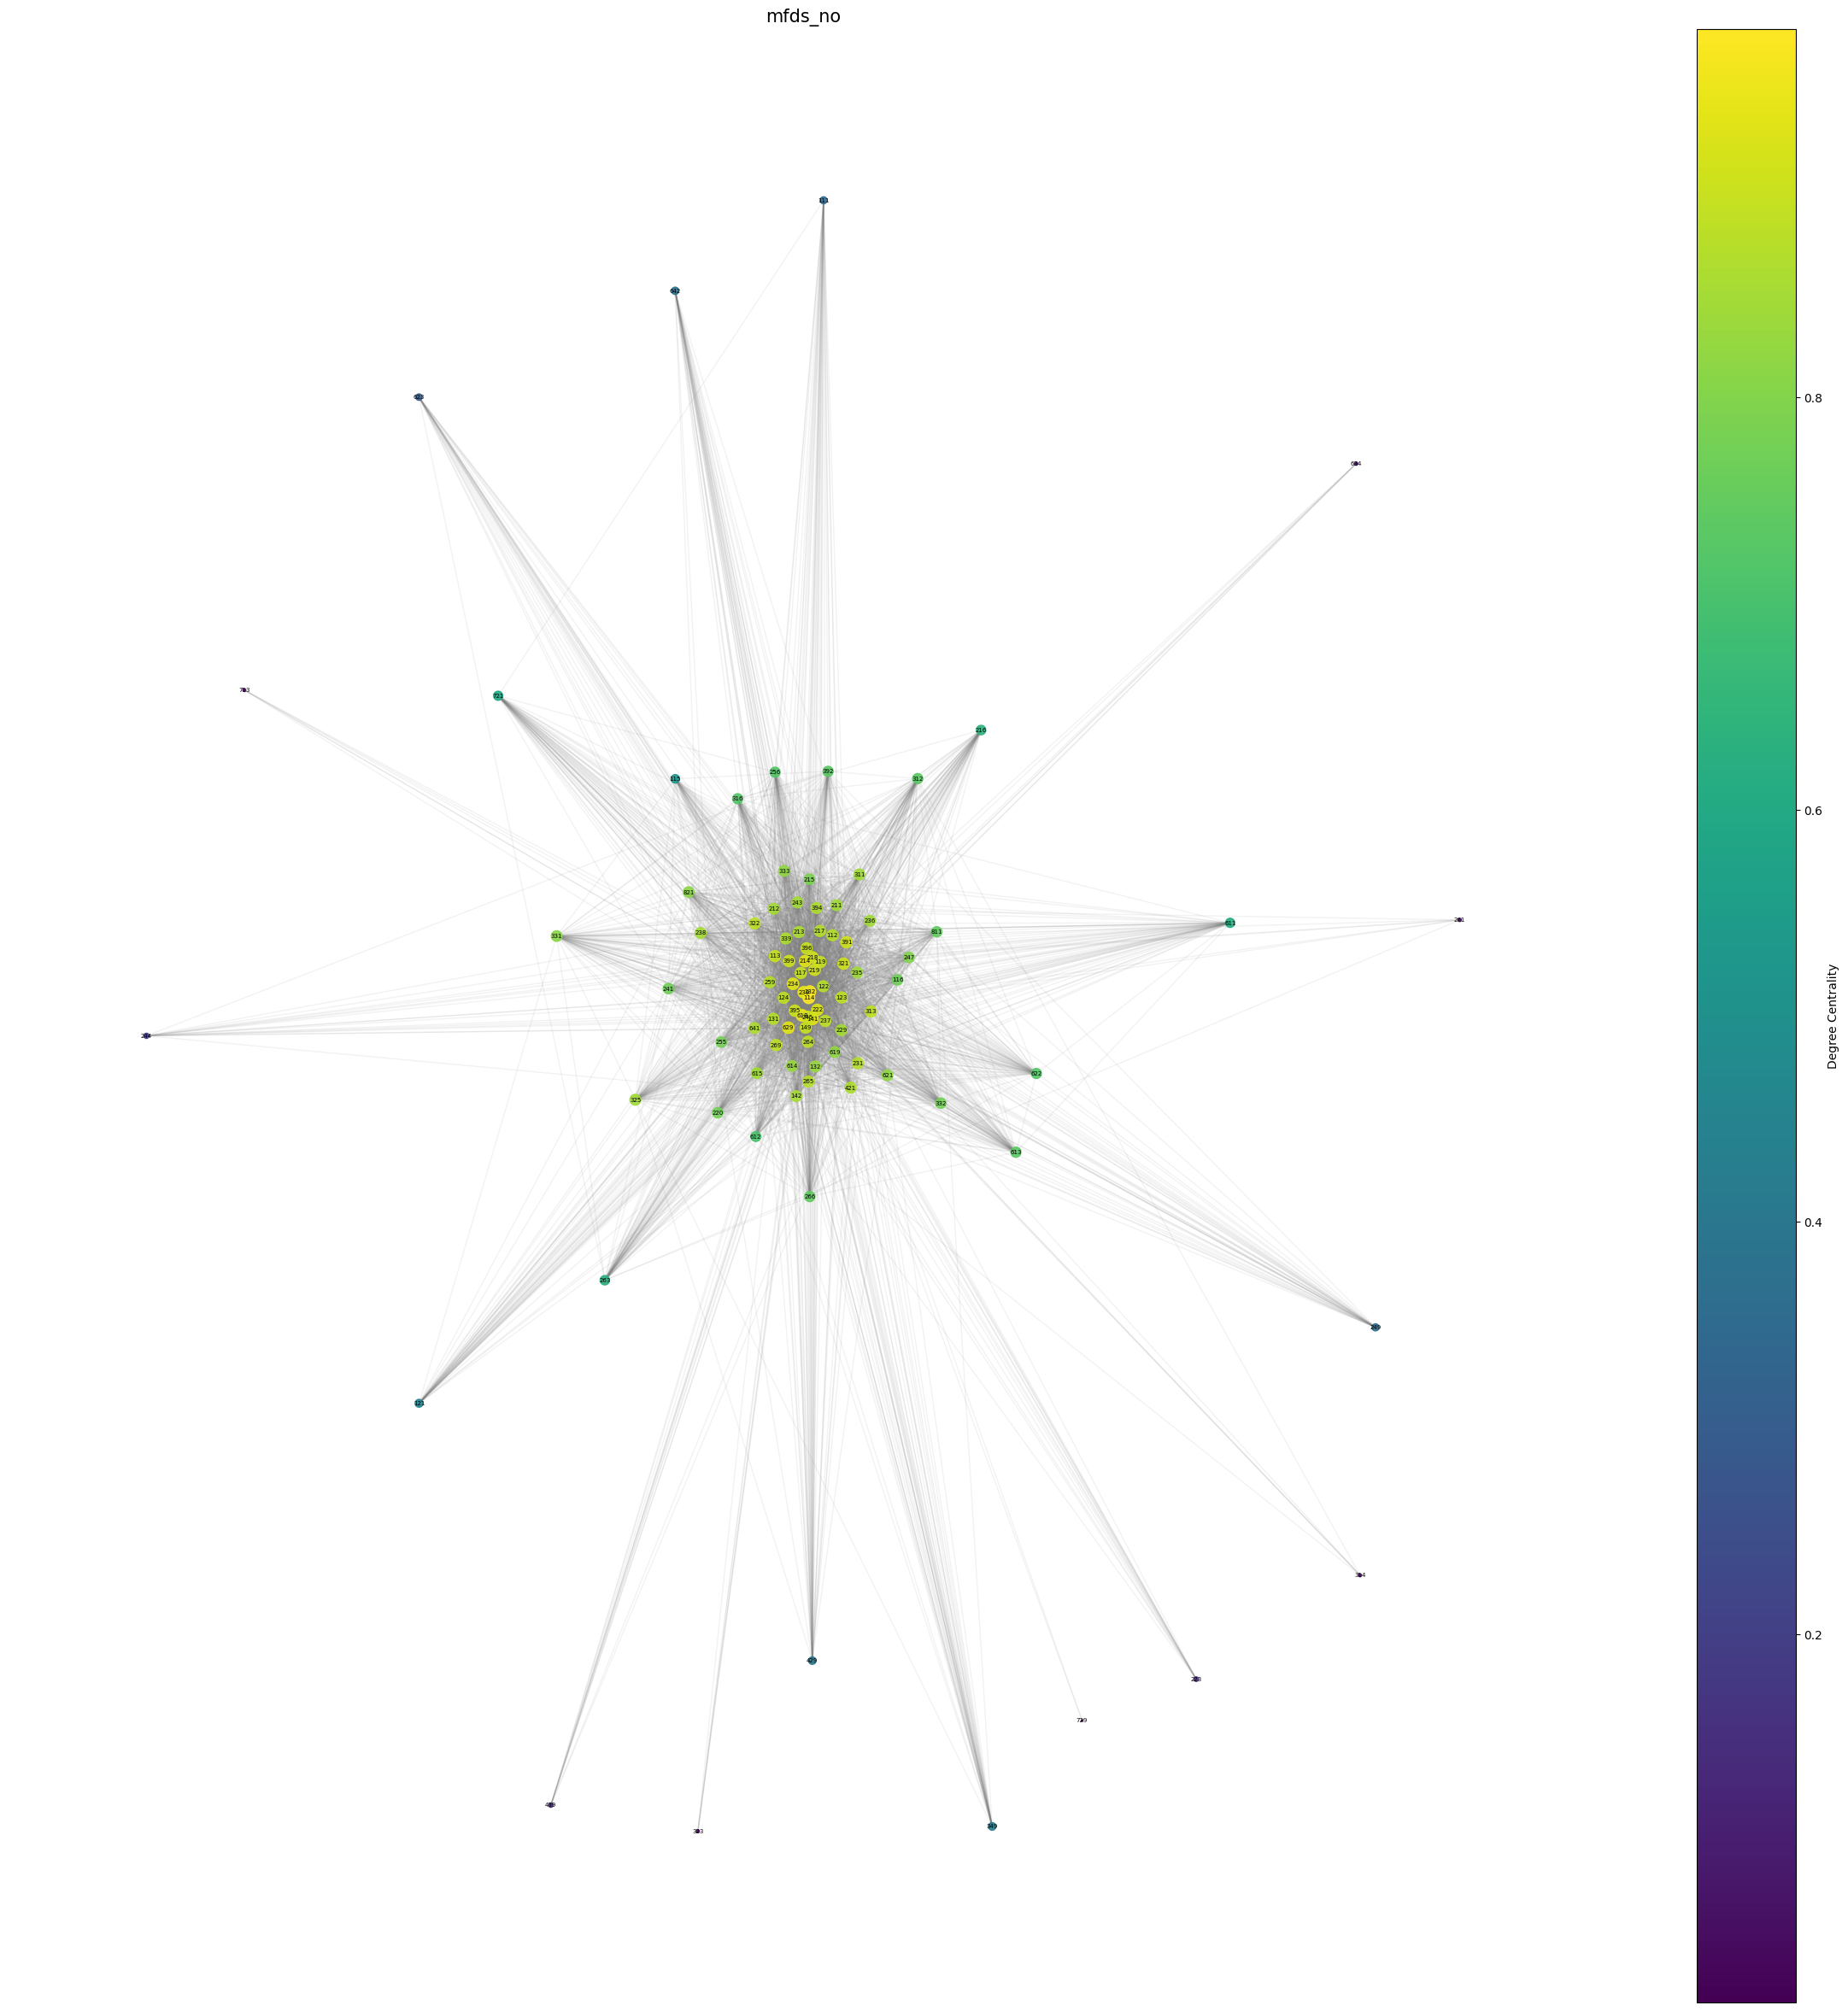

In [ ]:
G = nx.from_pandas_edgelist(df_grouped, 'source', 'target', ['weight'])

degree_centrality = nx.degree_centrality(G)
node_size = [v * 100 for v in degree_centrality.values()]
node_color = list(degree_centrality.values())

# 레이아웃 설정
pos = nx.spring_layout(G, seed=42, k=5)  # 시드 값을 설정하여 재현 가능하게 함

# 그래프 시각화
plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=5, font_color='black')

# 색상 바 추가
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title("mfds_no", size=15)
plt.axis('off')
plt.show() #주성분코드 전부 다

In [ ]:
nodes_of_interest = [
    114, 117, 119, 122, 131, 142, 214, 217, 218, 219,
    222, 232, 239, 241, 247, 259, 322, 323, 325, 331,
    333, 339, 349, 391, 392, 396, 399, 421, 618, 629,
    713]
black_list = [
    142, 214, 217, 218, 219,
    232, 239, 259, 325, 396]

In [ ]:
degree_centrality

{}

<ipython-input-16-e26925885a88>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Degree Centrality')


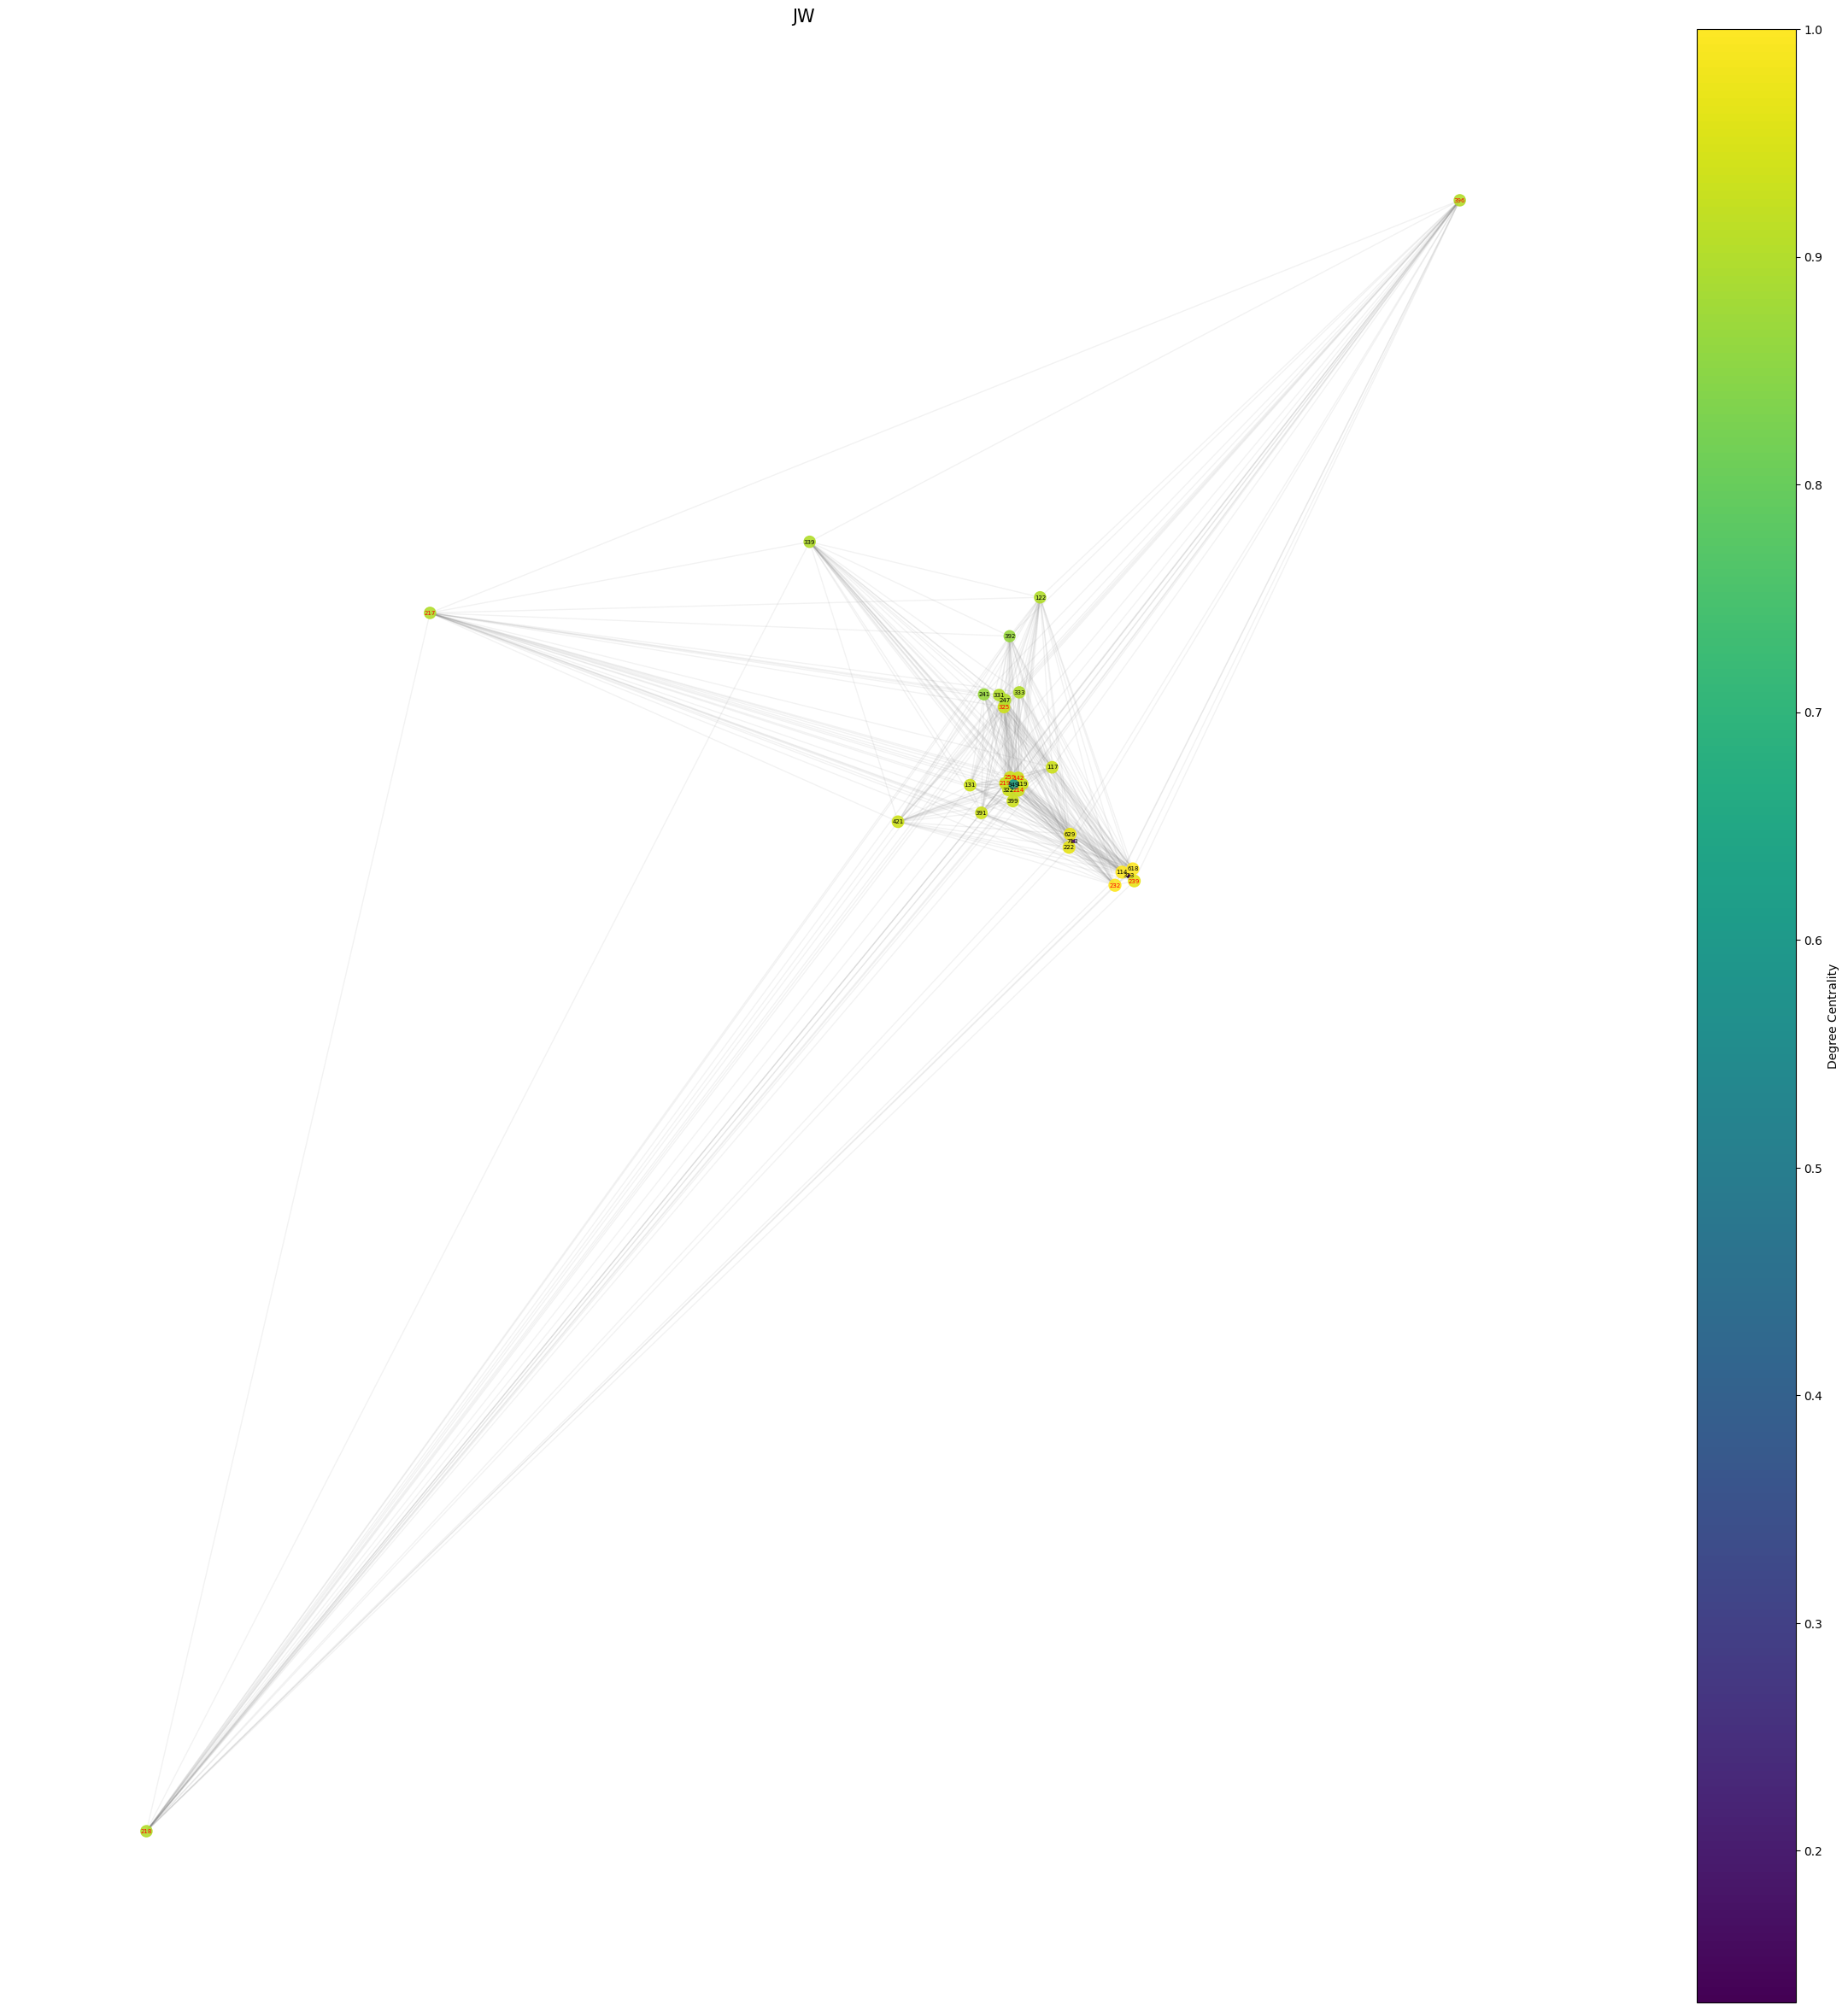

In [ ]:
#엣지 형성
all_combinations2 = []

combinations = list(itertools.combinations(nodes_of_interest, 2))
all_combinations2.extend(combinations)

df_sna_interest = pd.DataFrame(all_combinations2, columns=['source', 'target'])


# 관심 있는 노드들
interestgraph_nodes = nodes_of_interest

# 서브그래프 생성
interestgraph = G.subgraph(interestgraph_nodes)
nx.to_numpy_array(interestgraph)

# 중심성 계산 (degree centrality)
degree_centrality = nx.degree_centrality(interestgraph)

# 중심성을 크기와 색으로 매핑
node_size = [degree_centrality[node] * 100 for node in interestgraph.nodes()]
node_color = [degree_centrality[node] for node in interestgraph.nodes()]

# 레이아웃 설정
pos = nx.kamada_kawai_layout(interestgraph)

# 그래프 시각화
plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(interestgraph, pos, alpha=0.1, edge_color='gray')
nodes = nx.draw_networkx_nodes(interestgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)
#nx.draw_networkx_labels(interestgraph, pos, font_color='black')

#labels = nx.get_edge_attributes(interestgraph, 'weight')
#nx.draw_networkx_edge_labels(interestgraph, pos, edge_labels=labels)

for node, (x, y) in pos.items():
    if node in black_list:
        plt.text(x, y, node, fontsize=5, color='red', ha='center', va='center') # 리베이트 약품 이름 빨강으로
    else :
        plt.text(x, y, node, fontsize=5, color='black', ha='center', va='center')

# 색상 바 추가
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title('JW', size=15)
plt.axis('off')
plt.show()

In [ ]:
nodes_of_interest = [
    113, 114, 117, 119, 122, 124, 131, 132, 141, 149,
    214, 218, 219, 222, 229, 232, 239, 245, 259, 264,
    265, 269, 339, 391, 395, 396, 399, 611, 612, 614,
    615, 618, 619, 629]
black_list = [117, 131, 149, 214, 265, 396, 618, 619, 629]

<ipython-input-18-f5789733f57e>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Degree Centrality')


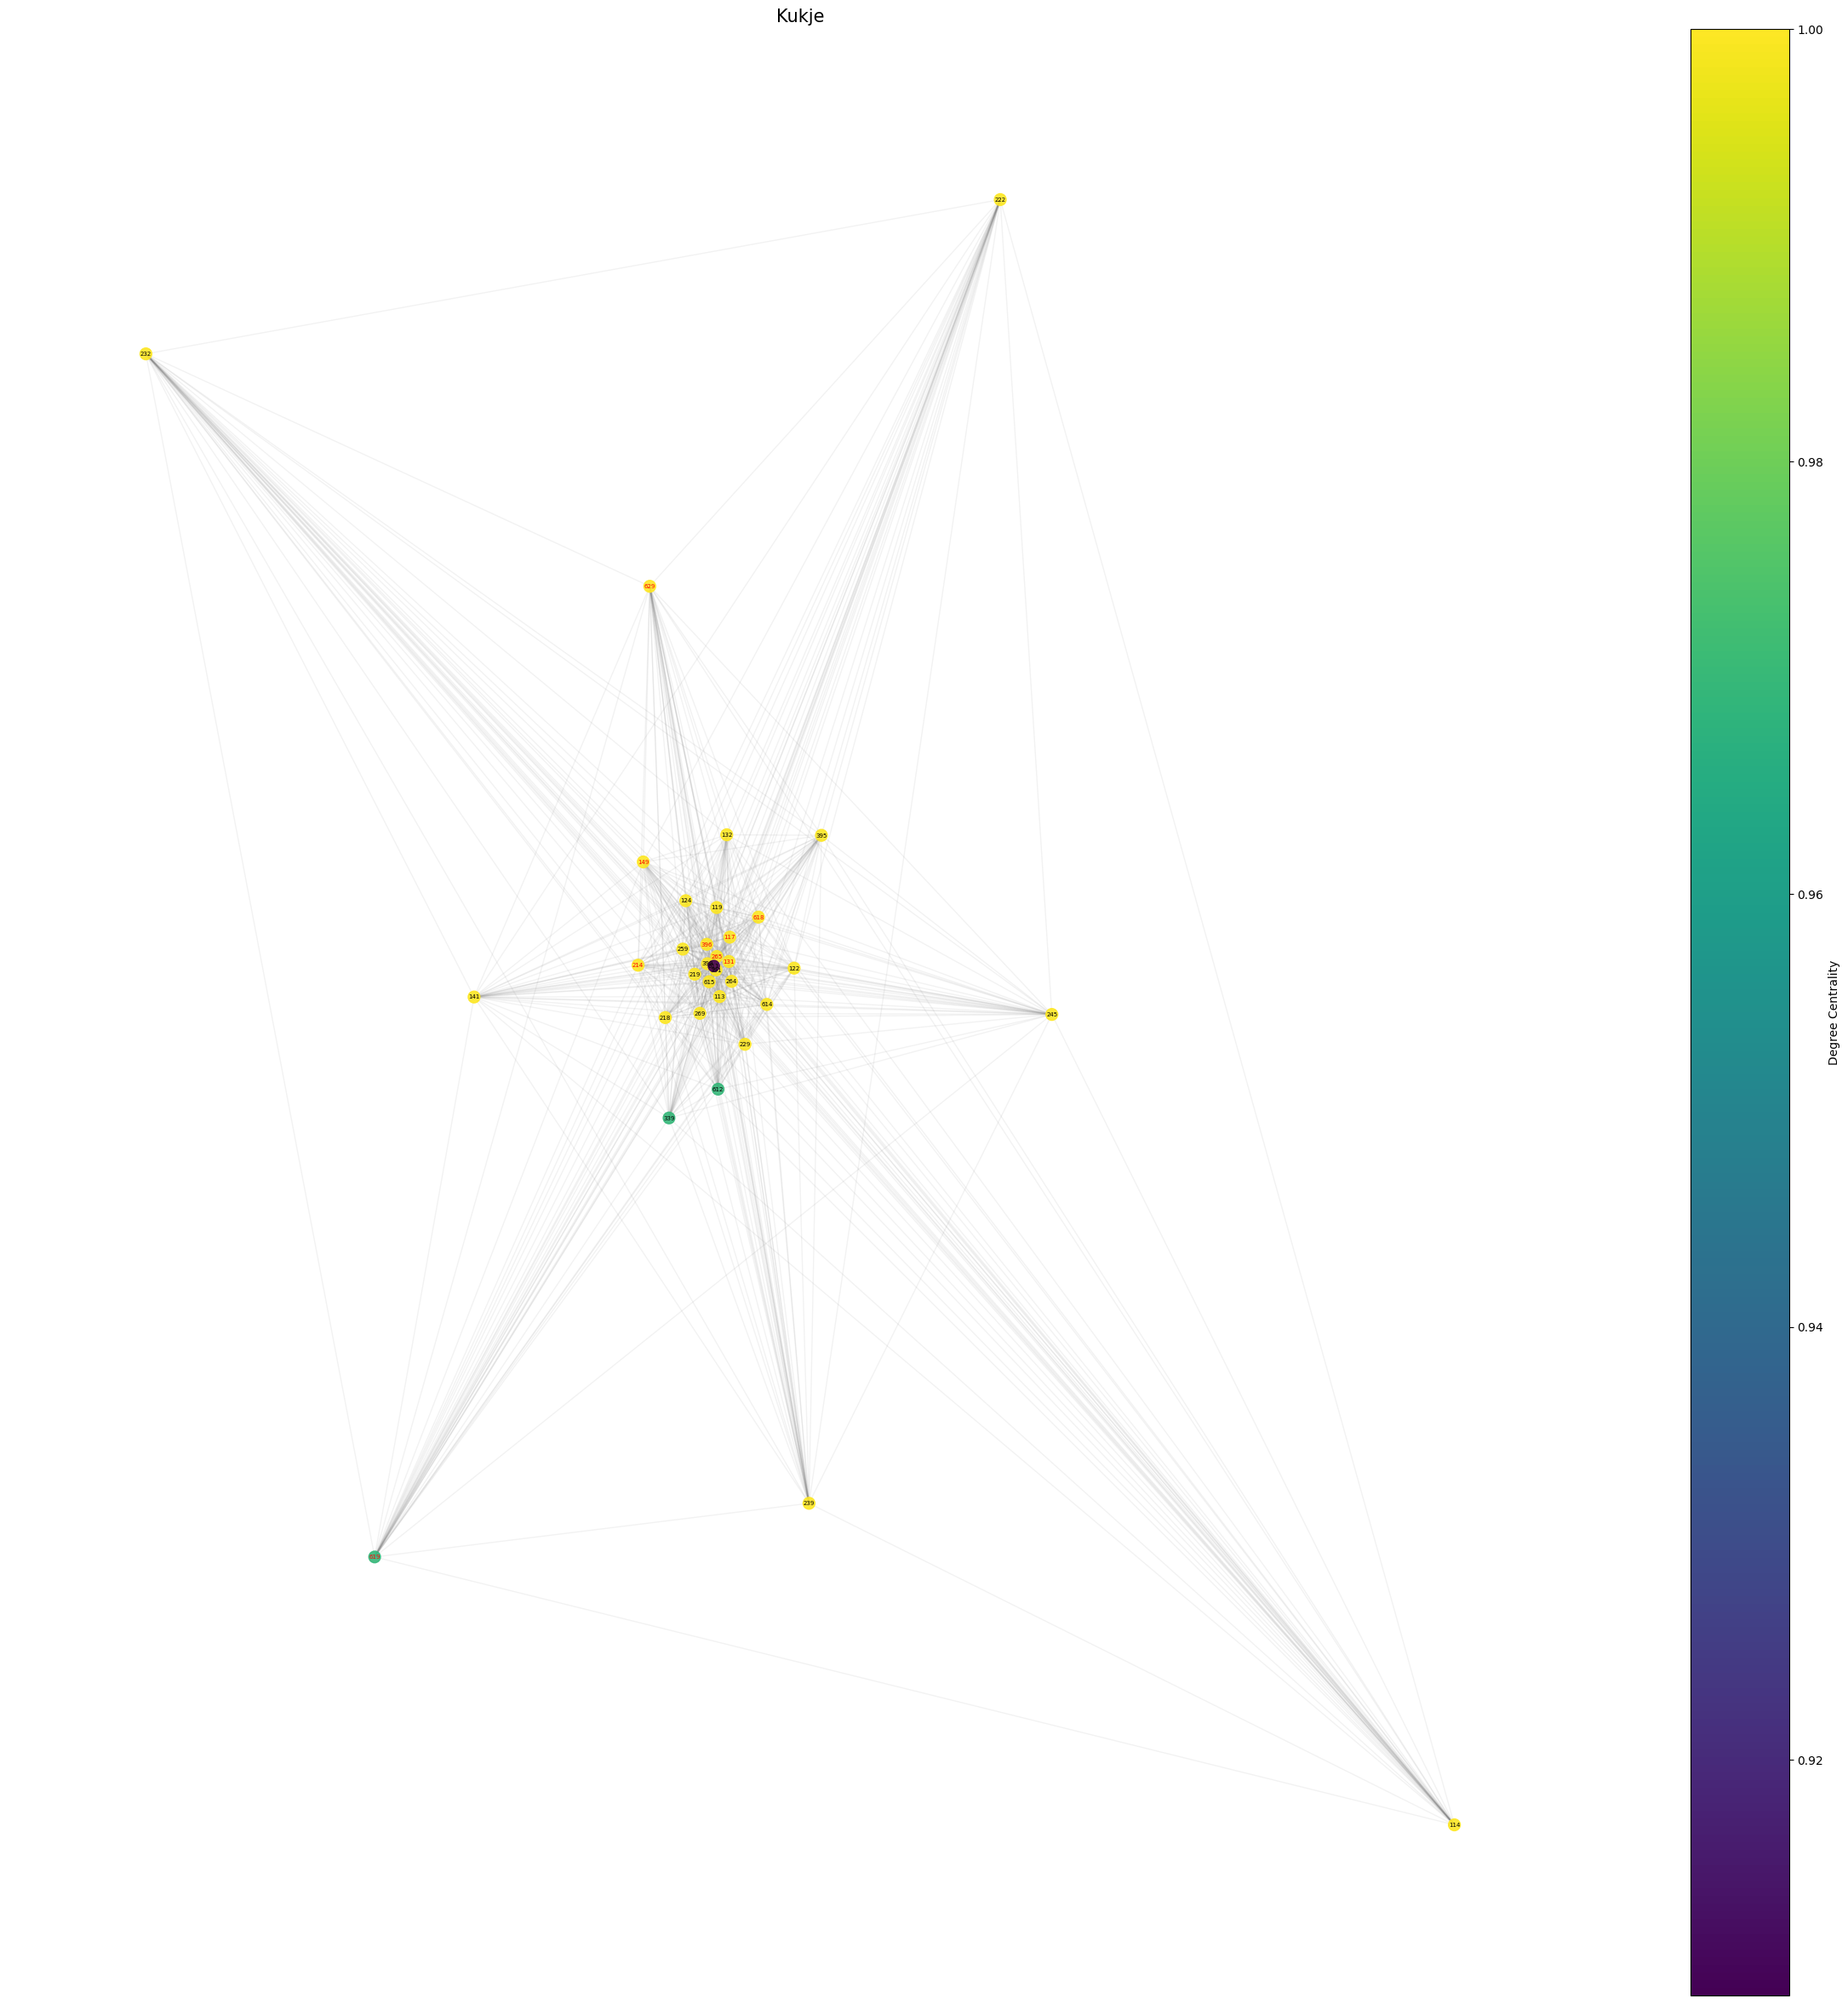

In [ ]:
#엣지 형성
all_combinations2 = []

combinations = list(itertools.combinations(nodes_of_interest, 2))
all_combinations2.extend(combinations)

df_sna_interest = pd.DataFrame(all_combinations2, columns=['source', 'target'])


# 관심 있는 노드들
interestgraph_nodes = nodes_of_interest

# 서브그래프 생성
interestgraph = G.subgraph(interestgraph_nodes)
nx.to_numpy_array(interestgraph)

# 중심성 계산 (degree centrality)
degree_centrality = nx.degree_centrality(interestgraph)

# 중심성을 크기와 색으로 매핑
node_size = [degree_centrality[node] * 100 for node in interestgraph.nodes()]
node_color = [degree_centrality[node] for node in interestgraph.nodes()]

# 레이아웃 설정
pos = nx.kamada_kawai_layout(interestgraph)

# 그래프 시각화
plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(interestgraph, pos, alpha=0.1, edge_color='gray')
nodes = nx.draw_networkx_nodes(interestgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)
#nx.draw_networkx_labels(interestgraph, pos, font_color='black')

#labels = nx.get_edge_attributes(interestgraph, 'weight')
#nx.draw_networkx_edge_labels(interestgraph, pos, edge_labels=labels)

for node, (x, y) in pos.items():
    if node in black_list:
        plt.text(x, y, node, fontsize=5, color='red', ha='center', va='center') # 리베이트 약품 이름 빨강으로
    else :
        plt.text(x, y, node, fontsize=5, color='black', ha='center', va='center')

# 색상 바 추가
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title('Kukje', size=15)
plt.axis('off')
plt.show()

In [ ]:
nodes_of_interest = [
    113, 114, 117, 119, 122, 124, 132, 141, 149, 214,
    218, 219, 222, 229, 232, 239, 245, 259, 264, 265,
    269, 311, 339, 391, 396, 399, 612, 614, 618, 619,
    629, 721]
black_list = [
    113, 114, 117, 122, 124, 132, 141, 214, 218, 219,
    222, 232, 239, 245, 259, 264, 265, 339, 391, 396,
    399, 614, 618, 629]

<ipython-input-54-728396704041>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Degree Centrality')


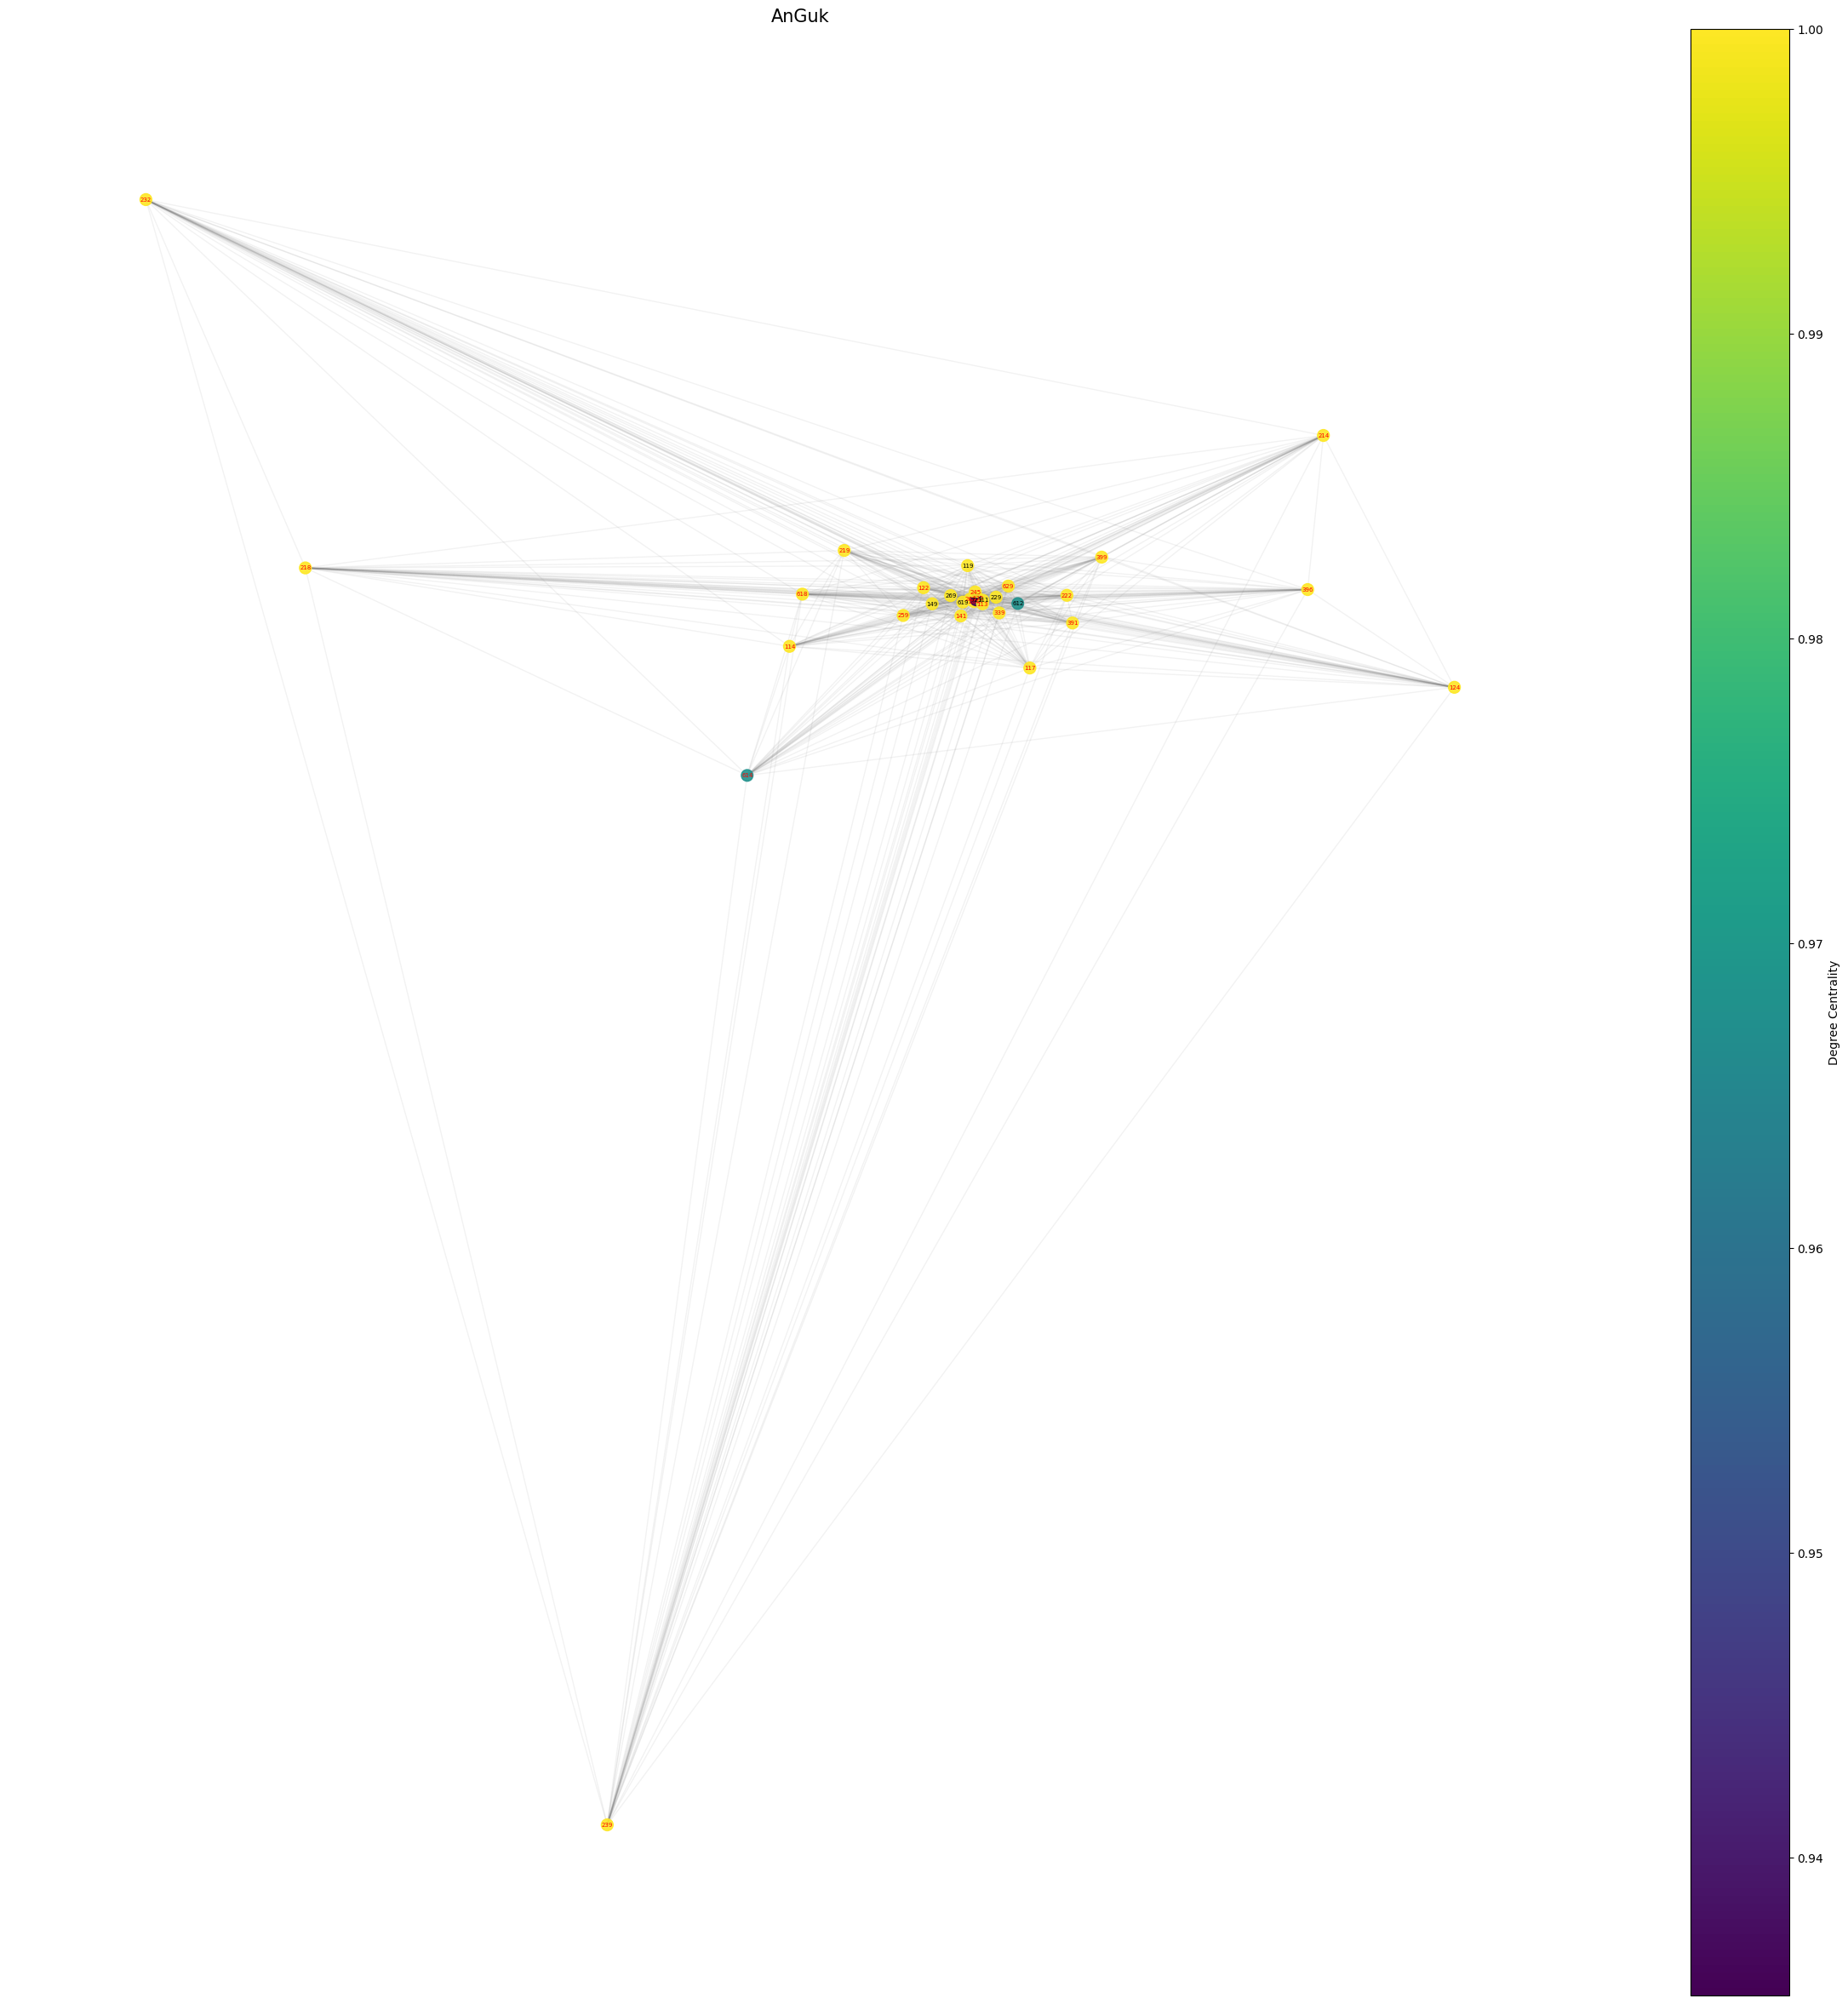

In [ ]:
#엣지 형성
all_combinations2 = []

combinations = list(itertools.combinations(nodes_of_interest, 2))
all_combinations2.extend(combinations)

df_sna_interest = pd.DataFrame(all_combinations2, columns=['source', 'target'])


# 관심 있는 노드들
interestgraph_nodes = nodes_of_interest

# 서브그래프 생성
interestgraph = G.subgraph(interestgraph_nodes)
nx.to_numpy_array(interestgraph)

# 중심성 계산 (degree centrality)
degree_centrality = nx.degree_centrality(interestgraph)

# 중심성을 크기와 색으로 매핑
node_size = [degree_centrality[node] * 100 for node in interestgraph.nodes()]
node_color = [degree_centrality[node] for node in interestgraph.nodes()]

# 레이아웃 설정
pos = nx.kamada_kawai_layout(interestgraph)

# 그래프 시각화
plt.figure(figsize=(30, 30))
nx.draw_networkx_edges(interestgraph, pos, alpha=0.1, edge_color='gray')
nodes = nx.draw_networkx_nodes(interestgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)
#nx.draw_networkx_labels(interestgraph, pos, font_color='black')

#labels = nx.get_edge_attributes(interestgraph, 'weight')
#nx.draw_networkx_edge_labels(interestgraph, pos, edge_labels=labels)

for node, (x, y) in pos.items():
    if node in black_list:
        plt.text(x, y, node, fontsize=5, color='red', ha='center', va='center') # 리베이트 약품 이름 빨강으로
    else :
        plt.text(x, y, node, fontsize=5, color='black', ha='center', va='center')

# 색상 바 추가
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color)))
sm.set_array([])
plt.colorbar(sm, label='Degree Centrality')

plt.title('AnGuk', size=15)
plt.axis('off')
plt.show()